# Grupo 8 - Base de Datos Olist

**Integrantes:**
 - Ignacio Cordoba
 - Sebastin Ignacio Lezama
 - Alejandro Mezio
 - Diego Nicolás Zallio


## 8.&nbsp;Modelo de predicción

### Librerías

In [2]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import randint, uniform, loguniform

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Herramientas de preprocesado y métricas
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV # Alternativa a GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, accuracy_score, make_scorer

# Herramientas para armar pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance as xgb_plot_importance
from sklearn.svm import LinearSVR # SVR

# Para guardar modelos ya entrenados
import pickle

In [4]:
pd.options.mode.copy_on_write = True
pd.options.mode.chained_assignment = 'raise'

In [5]:
# carpeta "models" donde guardamos los modelos entrenados
models_path = './models'
os.makedirs(models_path, exist_ok=True)

---

### Carga de datos

In [6]:
# Función para cargar los dataframes junto con sus diccionarios de datatypes
def load_dataframe(base_path, name):
    dtype_path = Path(base_path) / f"{name}_datatypes.txt"
    csv_path = Path(base_path) / f"{name}.csv"
    
    with open(dtype_path, "r") as file:
        datatypes = json.load(file)

    # Extraemos columnas de fechas
    datetime_cols = [col for col, dtype in datatypes.items() if dtype == 'datetime64[ns]']
    for col in datetime_cols:
        del datatypes[col]

    return pd.read_csv(csv_path, dtype=datatypes, parse_dates=datetime_cols)

In [7]:
base = "./bbdd_limpia"
name = "dataset_final_agrupado"
df_final = load_dataframe(base, name)

In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90137 entries, 0 to 90136
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_purchase_timestamp       90137 non-null  datetime64[ns]
 1   order_approved_at              90137 non-null  datetime64[ns]
 2   order_delivered_carrier_date   90137 non-null  datetime64[ns]
 3   order_delivered_customer_date  90137 non-null  datetime64[ns]
 4   order_estimated_delivery_date  90137 non-null  datetime64[ns]
 5   order_purchase_year            90137 non-null  int64         
 6   order_purchase_month           90137 non-null  int64         
 7   order_purchase_dayofmonth      90137 non-null  int64         
 8   order_purchase_dayofweek       90137 non-null  int64         
 9   order_purchase_year_month      90137 non-null  object        
 10  order_purchase_year_month_day  90137 non-null  object        
 11  order_purchase_

---

### Selección de variables

Separamos las columnas entre numéricas y categóricas, para realizarles un preprocesamiento diferente.

Aclaración sobre las cantidades relacionadas al target:

- `days_to_delivered` es el **target**, la variable `y`. Cuenta los días transcurridos desde que se hizo la compra y el pedido llegó al comprador.
- `days_estimated` es la estimación que hizo el "viejo" modelo de Olist que pretendemos mejorar.
- `days_predicted` es el nombre que le daremos a la predicción de nuestro modelo, el "nuevo" modelo. Es la variable `y_hat`.
- `days_base_model` es la estimación del modelo base (regresión lineal sin regularización) con la que pretendemos comparar la métrica de los modelos a evaluar.

El modelo viejo `days_estimated` puede pensarse como un punto de partida natural, pero también es un modelo que sobreestima (a veces groseramente) la variable target y no nos permitiría una comparación representativa del poder de predicción de los nuevos modelos. Al fin y al cabo, la discrepancia de este modelo "viejo" con el target es lo que motiva el objetivo de este proyecto.

Features utilizadas:
- `distance_km`
- `price`
- `freight_value`
- `product_chosen_weight`
- `sales_same_state`
- `product_venta`
- `rutas`

Otras posibles:
- `total_value`
- `product_rubro`

In [9]:
numerical_features = ['price', 'freight_value', 'product_chosen_weight', 'distance_km','sales_same_state'] # 'total_value',
categorical_features = ['product_venta', 'rutas'] # 'product_rubro'
target_columns = ['days_to_delivered', 'days_estimated']

X = df_final[numerical_features + categorical_features]
y = df_final[target_columns]

---

### Preprocesamiento

In [10]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

¿Usar o no `drop='first'` en OneHotEncoder?

Si tengo k categorías, esta subrutina creará k columnas binarias nuevas. Si incluimos todas en el modelo, habrá multicolinealidad perfecta. La opción `drop='first'` elimina una de esas columnas, quedando k-1 columnas linealmente independientes.

Pero también usar esta opción puede acarrear algunos inconvenientes. Leyendo sobre el tema, remarcamos estos dos:

- **Interpretabilidad:** Omitir una columna implica que los coeficientes de las columnas restantes se interpretan en relación con la categoría eliminada. Si bien este enfoque puede ser válido, se dificulta la interpretación de los resultados, especialmente si la primera categoría no es una línea base natural.

- **Modelos regularizados:** Si utilizamos modelos lineales regularizados (ej. Ridge, Lasso), la multicolinealidad suele ser un problema menor, ya que las técnicas de regularización pueden tratarla. En tales casos, eliminar una columna podría no ofrecer beneficios significativos, e incluso podría generarnos sesgo.

Por el momento no usaremos `drop='first'`.

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### División train/test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888)

Para evaluar si la división entre train y test del target (`days_to_delivered`) no está sesgada, lo cual nos podría generar algún problema de data leakage, es que graficamos la distribución del target en ambos datasets y comparamos.

También podría haber una especie de desbalanceo en el target (recordemos que es una variable continua).

También graficamos `days_estimated` que son los valores obtenidos por el estimador "viejo".

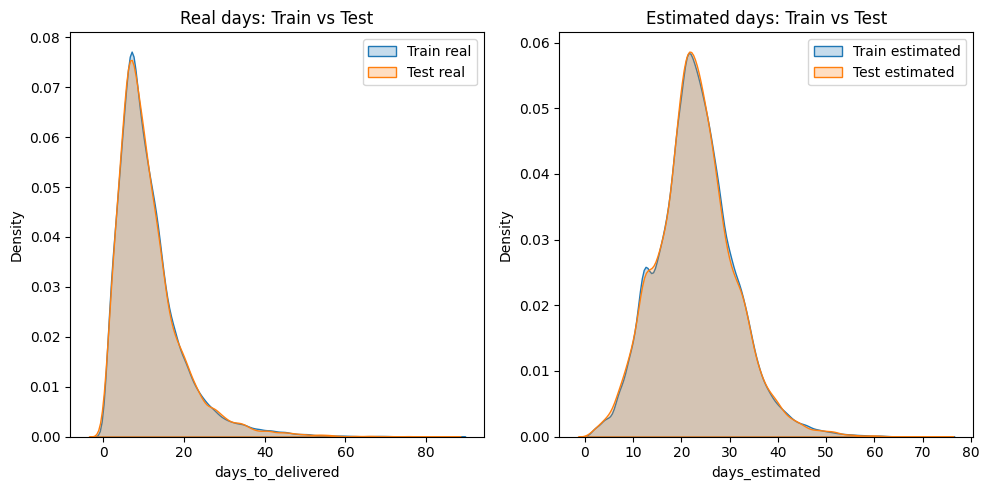

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(y_train['days_to_delivered'], ax=axes[0], label='Train real', fill=True)
sns.kdeplot(y_test['days_to_delivered'], ax=axes[0], label='Test real', fill=True)
axes[0].legend() ; axes[0].set_title('Real days: Train vs Test')

sns.kdeplot(y_train['days_estimated'], ax=axes[1], label='Train estimated', fill=True)
sns.kdeplot(y_test['days_estimated'], ax=axes[1], label='Test estimated', fill=True)
axes[1].legend() ; axes[1].set_title('Estimated days: Train vs Test')
plt.tight_layout() ; plt.show()

Ambas distribuciones son muy similares y, considerando la izquierda, no tendremos problema de desbalanceo del target.

### Métricas


Armamos una función de scoring que nos calcula MAE y RMSE:

In [14]:
scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
    }

Repasamos lo escrito en el siguiente artículo: [Which scoring function should I use?](https://scikit-learn.org/stable/modules/model_evaluation.html#which-scoring-function)

- MSE: El error cuadrático medio (o su raiz cuadrada) penaliza más los errores mas grandes, siendo mas sensible a outliers. Su interpretación no es tan directa.

- MAE: El error absoluto medio es más robusto y menos sensible a valores outliers. Su interpretación es más directa, ya que es el promedio de los errores.


Utilizaremos entonces MAE como métrica para el entrenamiento de los modelos, tendremos más interpretabilidad, aún cuando no amplificamos los errores más grandes.

Por otro lado, recordemos que MAE no es tan matematicamente suave y podríamos tener inconvenientes a la hora de optimizar.

### Modelos: Armado de pipelines y grilla de hiperparámetros

Utilizaremos varios modelos de regresión:

0) Regresión Lineal simple (este será nuestro modelo base de comparación)
1) Regresión Lineal con regularización L1 (Lasso)
2) Regresión Lineal con regularización L2 (Ridge)
3) Regresión Ridge con variable polinómicas de grado 2
4) Árbol de Decisión
5) Random Forest
6) eXtreme Gradient Boosting (XGBoost)
7) Support Vector Machine (SVM) Regressor
8) Stochastic Gradient Descent (SGD)

**NOTA:** En esta versión hemos agregado 3 modelos nuevos (xgb, svm y sgd) que no estaban en la presentación final original (y por lo tanto no se ven reflejados en el archivo `Informe Grupo 8 - Olist.pdf`).

#### 0. Modelo base: Regresión Lineal

Usaremos como punto de partida de modelo base una regresión lineal simple sin regularización

In [15]:
linreg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linreg', LinearRegression())
])

parameters_linreg ={}

grid_search_linreg = GridSearchCV(linreg_model, parameters_linreg,
                                  scoring=scoring, refit='mae',
                                  cv=5, n_jobs=-1)

#### 1. Lasso (L1)

Este modelo nos puede servir para evaluar si alguna de las features está de más.

In [16]:
lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(random_state=888))
])

parameters_lasso ={'lasso__alpha': [0.000001,
                                    0.00001,
                                    0.0001,
                                    0.001, 0.004, 0.005, 0.006,
                                    0.01, 0.015, 0.02,
                                    0.1,
                                    1.,
                                    10]}

grid_search_lasso = GridSearchCV(lasso_model, parameters_lasso,
                                 scoring=scoring, refit='mae',
                                 cv=5, n_jobs=-1)

#### 2. Ridge (L2)

In [17]:
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(random_state=888))
])

parameters_ridge ={'ridge__alpha': [0.001,
                                    0.01,
                                    0.1,
                                    1,
                                    10, 50,
                                    100, 150, 200, 250, 300, 500,
                                    1000,
                                    10000]}

grid_search_ridge = GridSearchCV(ridge_model, parameters_ridge,
                                 scoring=scoring, refit='mae',
                                 cv=5, n_jobs=-1)

#### 3. Ridge + variables polinómicas de grado 2

In [18]:
polinomial_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge(random_state=888))
])

parameters_poly ={'ridge__alpha': [0.01,
                                   0.1,
                                   1, 5, 6, 7, 8, 9,
                                   10, 12, 15, 20, 50,
                                   100,
                                   1000,
                                   10000]}

grid_search_poly = GridSearchCV(polinomial_model, parameters_poly, scoring=scoring, refit='mae', cv=5, n_jobs=-1)

#### 4. Decision Tree

In [19]:
tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeRegressor(random_state=888))
])

parameters_tree = {'tree__max_depth': [5, 7, 10, 15, 20],
                   'tree__max_features': ['sqrt', None],
                   'tree__min_samples_split': [2, 3, 5, 8],
                   'tree__min_samples_leaf': [50, 100, 200, 300, 400, 500],
                   }

grid_search_tree = GridSearchCV(tree_model, parameters_tree, scoring=scoring, refit='mae', cv=5, n_jobs=-1)

#### 5. Random forest

Como GridSearchCV consume mucho tiempo al querer entrenar un modelo de Random Forest, optamos por utilizar una versión optimizada: RandomizedSearchCV

In [20]:
forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('forest', RandomForestRegressor(random_state=888))
])

param_distributions_forest = {
    'forest__n_estimators': randint(100, 1000),
    'forest__max_depth': randint(5, 50),
    'forest__max_features': ['sqrt', 'log2'],
    'forest__min_samples_split': randint(2, 20),
    'forest__min_samples_leaf': randint(1, 10) }

randomized_search_forest = RandomizedSearchCV(forest_model, param_distributions_forest,
                                              scoring=scoring, refit='mae', n_iter=50,
                                              cv=5, n_jobs=-1, verbose=3)

Aclaración de este tipo de validación cruzada: `The search is non-exhaustive but often finds near-optimal results much faster than grid search`

#### 6. XGBoost

In [21]:
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(
        objective='reg:absoluteerror',  #   squarederror  pseudohubererror
        eval_metric='mae',
        random_state=888,
        tree_method='hist'  # often faster; replace with 'auto' if needed
    ))
])

param_distributions_xgb = {
    'xgb__n_estimators': randint(500, 1500),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.005, 0.055),
    'xgb__subsample': uniform(0.5, 1.0),
    'xgb__colsample_bytree': uniform(0.5, 1.0),
    'xgb__min_child_weight': randint(5, 20),
    'xgb__gamma': uniform(0.0, 1.0),              # Lower gamma: MAE benefits from more flexible splits
    'xgb__reg_alpha': uniform(0.0, 2.0),          # L1
    'xgb__reg_lambda': uniform(0.5, 2.0),         # L2
    'xgb__gamma': uniform(0.0, 1.0)               # Smooth split penalty
}

randomized_search_xgb = RandomizedSearchCV(xgb_model, param_distributions_xgb,
                                           scoring=scoring, refit='mae', n_iter=50, 
                                           cv=5, n_jobs=-1, verbose=3)

#### 7. SVM Regressor (LinearSVR)

In [22]:
linear_svr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', LinearSVR(
        loss='epsilon_insensitive',
        epsilon=0,
        random_state=888
    ))
])

param_distributions_linear_svr = {
    'svr__C': loguniform(1e-3, 1e2),
    'svr__epsilon': uniform(0.0, 1.0),  # 0.00 – 1.00
    'svr__max_iter': [5000, 10000, 20000],
    'svr__tol': loguniform(1e-5, 1e-2)
}

randomized_search_linear_svr = RandomizedSearchCV(linear_svr_model, param_distributions_linear_svr,
                                                  scoring=scoring, refit='mae', n_iter=40,   # fewer needed because search space is small
                                                  cv=5, n_jobs=-1, verbose=3)

#### 8. SGD Regressor

In [23]:
sgd_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sgd', SGDRegressor(
        loss='epsilon_insensitive',  # SVR-like loss
        epsilon=0,
        random_state=888,
        penalty='elasticnet',        # elastic net works well in high dimensions
        max_iter=5000,
        tol=1e-3
    ))
])

param_distributions_sgd = {
    'sgd__alpha': loguniform(1e-6, 1e-2),         # regularization strength
    'sgd__l1_ratio': uniform(0.0, 1.0),           # elastic net mixing
    'sgd__epsilon': uniform(0.0, 1.0),
    'sgd__eta0': loguniform(1e-4, 1e-1),          # initial learning rate
    'sgd__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'sgd__max_iter': [2000, 5000, 10000],
    'sgd__tol': loguniform(1e-5, 1e-2)
}

randomized_search_sgd = RandomizedSearchCV(sgd_model, param_distributions_sgd,
                                           scoring=scoring, refit='mae', n_iter=50,
                                           cv=5, n_jobs=-1, verbose=3)

### Modelos: Entrenamiento

Para evitar tener que re-entrenar un modelo fuimos guardandolos en la carpeta `models` mediante el módulo `pickle`.

#### <u>0. Modelo base</u>


In [24]:
model_name = 'linreg_model.pkl'
linreg_path = os.path.join(models_path, model_name)

In [25]:
# grid_search_linreg.fit(X_train, y_train['days_to_delivered'])

In [26]:
# with open(linreg_path, 'wb') as file:
#     pickle.dump(grid_search_linreg, file)

In [27]:
with open(linreg_path,'rb') as model_file:
  grid_search_linreg = pickle.load(model_file)

In [28]:
grid_search_linreg.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse', 'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse'])

In [29]:
results_linreg = pd.DataFrame(grid_search_linreg.cv_results_)
results_linreg[['mean_test_mae', 'std_test_mae', 'mean_test_rmse', 'std_test_rmse']]

,mean_test_mae,std_test_mae,mean_test_rmse,std_test_rmse
0,-4.824247,0.034458,-7.14798,0.110177


In [30]:
results_linreg[['split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae']]

,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae
0,-4.877353,-4.797503,-4.778271,-4.827151,-4.840958


Guardamos predicciones base en variable 'days_base_model':

In [31]:
y_train['days_base_model'] = grid_search_linreg.predict(X_train)
y_test['days_base_model'] = grid_search_linreg.predict(X_test)

---

#### <u>1. Lasso</u>

In [32]:
model_name = 'lasso_model.pkl'
lasso_path = os.path.join(models_path, model_name)

In [33]:
# grid_search_lasso.fit(X_train, y_train['days_to_delivered'])

In [34]:
# with open(lasso_path, 'wb') as file:
#     pickle.dump(grid_search_lasso, file)

In [35]:
with open(lasso_path,'rb') as model_file:
  grid_search_lasso = pickle.load(model_file)

In [36]:
print("Best alpha:", grid_search_lasso.best_params_['lasso__alpha'])
print("Best MAE (CV):", -grid_search_lasso.best_score_)

Best alpha: 0.006
Best MAE (CV): 4.82355934123936


In [37]:
results_lasso = pd.DataFrame(grid_search_lasso.cv_results_)
results_lasso[['param_lasso__alpha',
               'mean_test_mae', 'std_test_mae',
               'mean_test_rmse', 'std_test_rmse'
               ]].sort_values(by='mean_test_mae', ascending=False).head(5)

,param_lasso__alpha,mean_test_mae,std_test_mae,mean_test_rmse,std_test_rmse
6,0.006,-4.823559,0.035101,-7.148519,0.110613
5,0.005,-4.823603,0.034977,-7.148354,0.110558
7,0.010,-4.823638,0.035572,-7.149468,0.110826
4,0.004,-4.823676,0.034849,-7.148211,0.110484
3,0.001,-4.824061,0.034539,-7.147983,0.110239


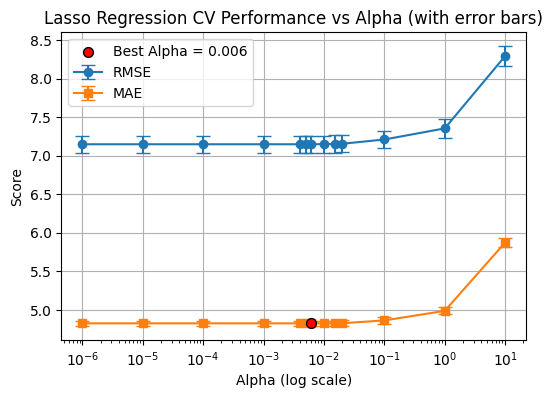

In [38]:
# Extract alphas, mean scores, std deviations
alphas = results_lasso['param_lasso__alpha'].astype(float)
mean_rmse = results_lasso['mean_test_rmse']; mean_mae = results_lasso['mean_test_mae']
std_rmse = results_lasso['std_test_rmse']; std_mae = results_lasso['std_test_mae']
# Using neg_* scorers, flip signs back
mean_rmse, std_rmse = -mean_rmse, std_rmse ; mean_mae, std_mae = -mean_mae, std_mae

# Get best alpha from grid search
best_alpha = grid_search_lasso.best_params_['lasso__alpha']
best_mae   = mean_mae[results_lasso['param_lasso__alpha'] == best_alpha].values[0]

plt.figure(figsize=(6,4))

plt.errorbar(alphas, mean_rmse, yerr=std_rmse, fmt='-o', capsize=5, label='RMSE')
plt.errorbar(alphas, mean_mae, yerr=std_mae, fmt='-s', capsize=5, label='MAE')

# Highlight best alpha point
plt.scatter(best_alpha, best_mae, color='red', s=50, edgecolor='black',
            zorder=5, label=f'Best Alpha = {best_alpha}')

plt.xscale('log'); plt.xlabel("Alpha (log scale)"); plt.ylabel("Score")
plt.title("Lasso Regression CV Performance vs Alpha (with error bars)")
plt.legend(); plt.grid(True); plt.show()

---

#### <u>2. Ridge</u>

In [39]:
model_name = 'ridge_model.pkl'
ridge_path = os.path.join(models_path, model_name)

In [40]:
# grid_search_ridge.fit(X_train, y_train['days_to_delivered'])

In [41]:
# with open(ridge_path, 'wb') as file:
#     pickle.dump(grid_search_ridge, file)

In [42]:
with open(ridge_path,'rb') as model_file:
  grid_search_ridge = pickle.load(model_file)

In [43]:
print("Best alpha:", grid_search_ridge.best_params_['ridge__alpha'])
print("Best MAE (CV):", -grid_search_ridge.best_score_)

Best alpha: 300
Best MAE (CV): 4.823270626741264


In [44]:
results_ridge = pd.DataFrame(grid_search_ridge.cv_results_)
results_ridge[['param_ridge__alpha',
               'mean_test_mae', 'std_test_mae',
               'mean_test_rmse', 'std_test_rmse'
               ]].sort_values(by='mean_test_mae', ascending=False).head(5)

,param_ridge__alpha,mean_test_mae,std_test_mae,mean_test_rmse,std_test_rmse
10,300.0,-4.823271,0.035203,-7.149247,0.110764
9,250.0,-4.823286,0.035087,-7.148888,0.110679
8,200.0,-4.823345,0.034964,-7.148575,0.110589
7,150.0,-4.823460,0.034837,-7.148315,0.110495
11,500.0,-4.823554,0.035655,-7.151004,0.111070


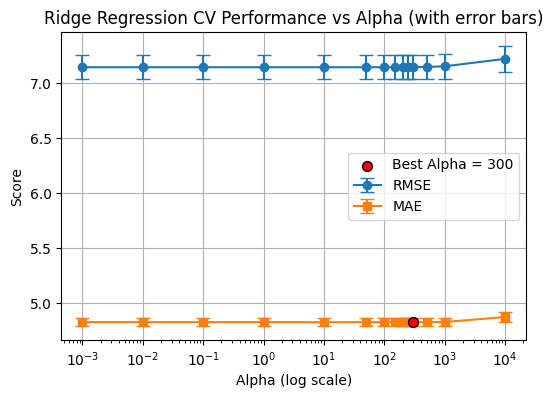

In [45]:
# Extract alphas, mean scores, std deviations
alphas = results_ridge['param_ridge__alpha'].astype(float)
mean_rmse = results_ridge['mean_test_rmse']; mean_mae = results_ridge['mean_test_mae']
std_rmse = results_ridge['std_test_rmse']; std_mae = results_ridge['std_test_mae']
# Using neg_* scorers, flip signs back
mean_rmse, std_rmse = -mean_rmse, std_rmse ; mean_mae, std_mae = -mean_mae, std_mae

# Get best alpha from grid search
best_alpha = grid_search_ridge.best_params_['ridge__alpha']
best_mae   = mean_mae[results_ridge['param_ridge__alpha'] == best_alpha].values[0]

plt.figure(figsize=(6,4))

plt.errorbar(alphas, mean_rmse, yerr=std_rmse, fmt='-o', capsize=5, label='RMSE')
plt.errorbar(alphas, mean_mae, yerr=std_mae, fmt='-s', capsize=5, label='MAE')

# Highlight best alpha point
plt.scatter(best_alpha, best_mae, color='red', s=50, edgecolor='black',
            zorder=5, label=f'Best Alpha = {best_alpha}')

plt.xscale('log') ; plt.xlabel("Alpha (log scale)") ; plt.ylabel("Score")
plt.title("Ridge Regression CV Performance vs Alpha (with error bars)")
plt.legend() ; plt.grid(True) ; plt.show()

---

#### <u>3. Ridge + Polinómicas</u>


In [46]:
model_name = 'poly_model.pkl'
poly_path = os.path.join(models_path, model_name)

In [47]:
# grid_search_poly.fit(X_train, y_train['days_to_delivered'])

In [48]:
# with open(poly_path, 'wb') as file:
#     pickle.dump(grid_search_poly, file)

In [49]:
with open(poly_path,'rb') as model_file:
  grid_search_poly = pickle.load(model_file)

In [50]:
print("Best alpha:", grid_search_poly.best_params_['ridge__alpha'])
print("Best MAE (CV):", -grid_search_poly.best_score_)

Best alpha: 7
Best MAE (CV): 4.780823987283601


In [51]:
results_poly = pd.DataFrame(grid_search_poly.cv_results_)
results_poly[['param_ridge__alpha',
              'mean_test_mae', 'std_test_mae',
              'mean_test_rmse', 'std_test_rmse'
              ]].sort_values(by='mean_test_mae', ascending=False).head(5)

,param_ridge__alpha,mean_test_mae,std_test_mae,mean_test_rmse,std_test_rmse
5,7.0,-4.780824,0.033468,-7.116747,0.106341
6,8.0,-4.780825,0.033461,-7.116739,0.106346
4,6.0,-4.780825,0.033476,-7.116756,0.106335
7,9.0,-4.780827,0.033454,-7.116733,0.106351
3,5.0,-4.780828,0.033485,-7.116767,0.106330


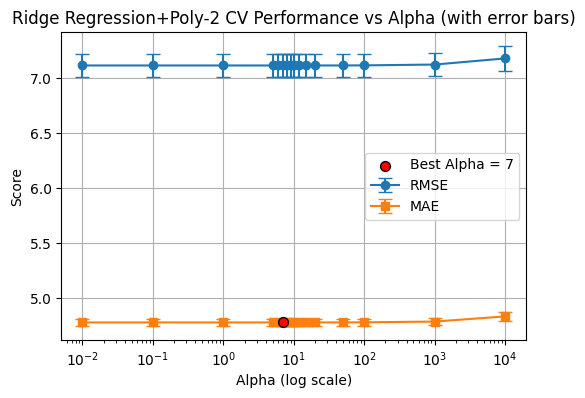

In [52]:
# Extract alphas, mean scores, std deviations
alphas = results_poly['param_ridge__alpha'].astype(float)
mean_rmse = results_poly['mean_test_rmse'] ; mean_mae = results_poly['mean_test_mae']
std_rmse = results_poly['std_test_rmse'] ; std_mae = results_poly['std_test_mae']
# Using neg_* scorers, flip signs back
mean_rmse, std_rmse = -mean_rmse, std_rmse ; mean_mae, std_mae = -mean_mae, std_mae

# Get best alpha from grid search
best_alpha = grid_search_poly.best_params_['ridge__alpha']
best_mae   = mean_mae[results_poly['param_ridge__alpha'] == best_alpha].values[0]

plt.figure(figsize=(6,4))

plt.errorbar(alphas, mean_rmse, yerr=std_rmse, fmt='-o', capsize=5, label='RMSE')
plt.errorbar(alphas, mean_mae, yerr=std_mae, fmt='-s', capsize=5, label='MAE')

# Highlight best alpha point
plt.scatter(best_alpha, best_mae, color='red', s=50, edgecolor='black',
            zorder=5, label=f'Best Alpha = {best_alpha}')

plt.xscale('log') ; plt.xlabel("Alpha (log scale)") ; plt.ylabel("Score")
plt.title("Ridge Regression+Poly-2 CV Performance vs Alpha (with error bars)")
plt.legend() ; plt.grid(True) ; plt.show()

---

#### <u>4. Decision Tree</u>

In [53]:
model_name = 'tree_model.pkl'
tree_path = os.path.join(models_path, model_name)

In [54]:
# grid_search_tree.fit(X_train, y_train['days_to_delivered'])

In [55]:
# with open(tree_path, 'wb') as file:
#     pickle.dump(grid_search_tree, file)

In [56]:
with open(tree_path,'rb') as model_file:
  grid_search_tree = pickle.load(model_file)

In [57]:
print("Best max_depth:", grid_search_tree.best_params_['tree__max_depth'])
print("Best max_features:", grid_search_tree.best_params_['tree__max_features'])
print("Best min_samples_leaf:", grid_search_tree.best_params_['tree__min_samples_leaf'])
print("Best min_samples_split:", grid_search_tree.best_params_['tree__min_samples_split'])
print("Best MAE (CV):", -grid_search_tree.best_score_)

Best max_depth: 10
Best max_features: None
Best min_samples_leaf: 200
Best min_samples_split: 2
Best MAE (CV): 4.756191301861419


In [58]:
results_tree = pd.DataFrame(grid_search_tree.cv_results_)
results_tree[['param_tree__max_depth',
              'param_tree__max_features',
              'param_tree__min_samples_leaf',
              'param_tree__min_samples_split',
              'mean_test_mae', 'std_test_mae',
              'mean_test_rmse', 'std_test_rmse']].sort_values(by='mean_test_mae', ascending=False).head(5)

,param_tree__max_depth,param_tree__max_features,param_tree__min_samples_leaf,param_tree__min_samples_split,mean_test_mae,std_test_mae,mean_test_rmse,std_test_rmse
128,10,None,200,2,-4.756191,0.038412,-7.105776,0.103474
129,10,None,200,3,-4.756191,0.038412,-7.105776,0.103474
130,10,None,200,5,-4.756191,0.038412,-7.105776,0.103474
131,10,None,200,8,-4.756191,0.038412,-7.105776,0.103474
132,10,None,300,2,-4.756893,0.035135,-7.103103,0.106709


In [59]:
grid_search_tree.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_tree__max_depth', 'param_tree__max_features', 'param_tree__min_samples_leaf', 'param_tree__min_samples_split', 'params', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse', 'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse'])

In [60]:
results_tree[['split0_test_mae',
              'split1_test_mae',
              'split2_test_mae',
              'split3_test_mae',
              'split4_test_mae',
              'mean_test_mae', 'std_test_mae'
              ]].sort_values(by='mean_test_mae', ascending=False).head(5)

,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae,mean_test_mae,std_test_mae
128,-4.824735,-4.718742,-4.721134,-4.753714,-4.762632,-4.756191,0.038412
129,-4.824735,-4.718742,-4.721134,-4.753714,-4.762632,-4.756191,0.038412
130,-4.824735,-4.718742,-4.721134,-4.753714,-4.762632,-4.756191,0.038412
131,-4.824735,-4.718742,-4.721134,-4.753714,-4.762632,-4.756191,0.038412
132,-4.814220,-4.727467,-4.714169,-4.757791,-4.770816,-4.756893,0.035135


---

#### <u>5. Random Forest</u>


In [61]:
model_name = 'forest_randomized_model.pkl'
forest_randomized_path = os.path.join(models_path, model_name)

In [62]:
# randomized_search_forest.fit(X_train, y_train['days_to_delivered'])

In [63]:
# with open(forest_randomized_path, 'wb') as file:
#     pickle.dump(randomized_search_forest, file)

In [64]:
with open(forest_randomized_path,'rb') as model_file:
  randomized_search_forest = pickle.load(model_file)

In [65]:
print("Best max_depth:", randomized_search_forest.best_params_['forest__max_depth'])
print("Best max_features:", randomized_search_forest.best_params_['forest__max_features'])
print("Best min_samples_leaf:", randomized_search_forest.best_params_['forest__min_samples_leaf'])
print("Best min_samples_split:", randomized_search_forest.best_params_['forest__min_samples_split'])
print("Best n_estimators:", randomized_search_forest.best_params_['forest__n_estimators'])
print("Best MAE (CV):", -randomized_search_forest.best_score_)

Best max_depth: 46
Best max_features: log2
Best min_samples_leaf: 7
Best min_samples_split: 10
Best n_estimators: 649
Best MAE (CV): 4.649673717390444


In [66]:
randomized_search_forest.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_forest__max_depth', 'param_forest__max_features', 'param_forest__min_samples_leaf', 'param_forest__min_samples_split', 'param_forest__n_estimators', 'params', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse', 'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse'])

In [67]:
results_forest_randomized = pd.DataFrame(randomized_search_forest.cv_results_)
results_forest_randomized[['param_forest__max_depth',
                           'param_forest__max_features',
                           'param_forest__min_samples_leaf',
                           'param_forest__min_samples_split',
                           'param_forest__n_estimators',
                           'mean_test_mae', 'std_test_mae',
                           'mean_test_rmse', 'std_test_rmse'
                           ]].sort_values(by='mean_test_mae', ascending=False).head(5)

,param_forest__max_depth,param_forest__max_features,param_forest__min_samples_leaf,param_forest__min_samples_split,param_forest__n_estimators,mean_test_mae,std_test_mae,mean_test_rmse,std_test_rmse
8,46,log2,7,10,649,-4.649674,0.034442,-6.985445,0.107975
38,48,log2,6,14,893,-4.649702,0.034782,-6.985564,0.107374
33,35,log2,5,17,959,-4.650062,0.034493,-6.985098,0.106039
5,40,sqrt,8,17,903,-4.650142,0.035100,-6.985344,0.107860
21,31,sqrt,6,8,644,-4.650258,0.034991,-6.985821,0.108306


In [68]:
results_forest_randomized[['split0_test_mae',
                           'split1_test_mae',
                           'split2_test_mae',
                           'split3_test_mae',
                           'split4_test_mae',
                           'mean_test_mae', 'std_test_mae'
                           ]].sort_values(by='mean_test_mae', ascending=False).head(5)

,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae,mean_test_mae,std_test_mae
8,-4.711771,-4.621457,-4.613940,-4.651081,-4.650119,-4.649674,0.034442
38,-4.712626,-4.619514,-4.615405,-4.651095,-4.649872,-4.649702,0.034782
33,-4.712232,-4.619206,-4.616677,-4.653821,-4.648374,-4.650062,0.034493
5,-4.713553,-4.619293,-4.615716,-4.651617,-4.650530,-4.650142,0.035100
21,-4.714047,-4.621005,-4.615710,-4.651568,-4.648959,-4.650258,0.034991


---

#### <u>6. XGBoost</u>


In [69]:
model_name = 'xgb_randomized_model.pkl'
xgb_randomized_path = os.path.join(models_path, model_name)

In [70]:
# randomized_search_xgb.fit(X_train, y_train['days_to_delivered'])

In [71]:
# with open(xgb_randomized_path, 'wb') as file:
#     pickle.dump(randomized_search_xgb, file)

In [72]:
with open(xgb_randomized_path,'rb') as model_file:
  randomized_search_xgb = pickle.load(model_file)

In [73]:
randomized_search_xgb.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_xgb__colsample_bytree', 'param_xgb__gamma', 'param_xgb__learning_rate', 'param_xgb__max_depth', 'param_xgb__min_child_weight', 'param_xgb__n_estimators', 'param_xgb__reg_alpha', 'param_xgb__reg_lambda', 'param_xgb__subsample', 'params', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse', 'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse'])

In [74]:
randomized_search_xgb.best_score_

np.float64(-4.427596950531006)

In [75]:
print("Best colsample_bytree:", randomized_search_xgb.best_params_['xgb__colsample_bytree'])
print("Best gamma:           ", randomized_search_xgb.best_params_['xgb__gamma'])
print("Best learning_rate:   ", randomized_search_xgb.best_params_['xgb__learning_rate'])
print("Best max_depth:       ", randomized_search_xgb.best_params_['xgb__max_depth'])
print("Best min_child_weight:", randomized_search_xgb.best_params_['xgb__min_child_weight'])
print("Best n_estimators:    ", randomized_search_xgb.best_params_['xgb__n_estimators'])
print("Best reg_alpha:       ", randomized_search_xgb.best_params_['xgb__reg_alpha'])
print("Best reg_lambda:      ", randomized_search_xgb.best_params_['xgb__reg_lambda'])
print("Best subsample:       ", randomized_search_xgb.best_params_['xgb__subsample'])
print("Best MAE (CV):        ", -randomized_search_xgb.best_score_)

Best colsample_bytree: 0.9473671498667567
Best gamma:            0.7176274029426006
Best learning_rate:    0.040574811555119
Best max_depth:        7
Best min_child_weight: 15
Best n_estimators:     1148
Best reg_alpha:        1.2281606958567808
Best reg_lambda:       2.047745290252175
Best subsample:        0.9080820523663289
Best MAE (CV):         4.427596950531006


---

#### <u>7. SVM Regressor</u>


In [76]:
model_name = 'svr_randomized_model.pkl'
svr_randomized_path = os.path.join(models_path, model_name)

In [77]:
# randomized_search_linear_svr.fit(X_train, y_train['days_to_delivered'])

In [78]:
# with open(svr_randomized_path, 'wb') as file:
#     pickle.dump(randomized_search_linear_svr, file)

In [79]:
with open(svr_randomized_path,'rb') as model_file:
  randomized_search_linear_svr = pickle.load(model_file)

In [80]:
randomized_search_linear_svr.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_svr__C', 'param_svr__epsilon', 'param_svr__max_iter', 'param_svr__tol', 'params', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse', 'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse'])

In [81]:
print("Best C:        ", randomized_search_linear_svr.best_params_['svr__C'])
print("Best epsilon:  ", randomized_search_linear_svr.best_params_['svr__epsilon'])
print("Best max_iter: ", randomized_search_linear_svr.best_params_['svr__max_iter'])
print("Best tol:      ", randomized_search_linear_svr.best_params_['svr__tol'])
print("Best MAE (CV): ", -randomized_search_linear_svr.best_score_)

Best C:         6.900322599178999
Best epsilon:   0.41511130549467934
Best max_iter:  20000
Best tol:       0.00015057583199205198
Best MAE (CV):  4.632912828271451


---

#### <u>8. SGD Regressor</u>


In [82]:
model_name = 'sgd_randomized_model.pkl'
sgd_randomized_path = os.path.join(models_path, model_name)

In [83]:
# randomized_search_sgd.fit(X_train, y_train['days_to_delivered'])

In [84]:
# with open(sgd_randomized_path, 'wb') as file:
#     pickle.dump(randomized_search_sgd, file)

In [85]:
with open(sgd_randomized_path,'rb') as model_file:
  randomized_search_sgd = pickle.load(model_file)

In [86]:
randomized_search_sgd.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_sgd__alpha', 'param_sgd__epsilon', 'param_sgd__eta0', 'param_sgd__l1_ratio', 'param_sgd__learning_rate', 'param_sgd__max_iter', 'param_sgd__tol', 'params', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse', 'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse'])

In [87]:
print("Best alpha:        ", randomized_search_sgd.best_params_['sgd__alpha'])
print("Best epsilon:  ", randomized_search_sgd.best_params_['sgd__epsilon'])
print("Best eta0:        ", randomized_search_sgd.best_params_['sgd__eta0'])
print("Best l1_ratio:        ", randomized_search_sgd.best_params_['sgd__l1_ratio'])
print("Best learning_rate:        ", randomized_search_sgd.best_params_['sgd__learning_rate'])
print("Best max_iter: ", randomized_search_sgd.best_params_['sgd__max_iter'])
print("Best tol:      ", randomized_search_sgd.best_params_['sgd__tol'])
print("Best MAE (CV): ", -randomized_search_sgd.best_score_)

Best alpha:         2.5990271103833668e-05
Best epsilon:   0.1453252408711273
Best eta0:         0.006716489734795898
Best l1_ratio:         0.43445146549689984
Best learning_rate:         adaptive
Best max_iter:  10000
Best tol:       0.008710885325920433
Best MAE (CV):  4.63285914174004


### Modelos: Comparación

Comparamos los valores de MAE y RMSE de los mejores estimadores de cada modelo, de esta manera elegiremos el que tenga menor MAE:

In [88]:
# ---- Linreg mean score ----
mean_mae_linreg = -grid_search_linreg.cv_results_['mean_test_mae'][0]
mean_rmse_linreg = -grid_search_linreg.cv_results_['mean_test_rmse'][0]

# ---- Lasso best scores ----
best_idx_lasso  =  grid_search_lasso.best_index_
best_mae_lasso  = -grid_search_lasso.cv_results_['mean_test_mae'][best_idx_lasso]
best_rmse_lasso = -grid_search_lasso.cv_results_['mean_test_rmse'][best_idx_lasso]

# ---- Ridge best scores ----
best_idx_ridge  =  grid_search_ridge.best_index_
best_mae_ridge  = -grid_search_ridge.cv_results_['mean_test_mae'][best_idx_ridge]
best_rmse_ridge = -grid_search_ridge.cv_results_['mean_test_rmse'][best_idx_ridge]

# ---- Poly best scores ----
best_idx_poly  =  grid_search_poly.best_index_
best_mae_poly  = -grid_search_poly.cv_results_['mean_test_mae'][best_idx_poly]
best_rmse_poly = -grid_search_poly.cv_results_['mean_test_rmse'][best_idx_poly]

# ---- Tree best scores ----
best_idx_tree  =  grid_search_tree.best_index_
best_mae_tree  = -grid_search_tree.cv_results_['mean_test_mae'][best_idx_tree]
best_rmse_tree = -grid_search_tree.cv_results_['mean_test_rmse'][best_idx_tree]

# ---- Random Forest best scores ----
best_idx_forest  =  randomized_search_forest.best_index_
best_mae_forest  = -randomized_search_forest.cv_results_['mean_test_mae'][best_idx_forest]
best_rmse_forest = -randomized_search_forest.cv_results_['mean_test_rmse'][best_idx_forest]

# ---- XGBoost best scores ----
best_idx_xgb  =  randomized_search_xgb.best_index_
best_mae_xgb  = -randomized_search_xgb.cv_results_['mean_test_mae'][best_idx_xgb]
best_rmse_xgb = -randomized_search_xgb.cv_results_['mean_test_rmse'][best_idx_xgb]

# ---- SVM Regressor best scores ----
best_idx_svr  =  randomized_search_linear_svr.best_index_
best_mae_svr  = -randomized_search_linear_svr.cv_results_['mean_test_mae'][best_idx_svr]
best_rmse_svr = -randomized_search_linear_svr.cv_results_['mean_test_rmse'][best_idx_svr]

# ---- SGD best scores ----
best_idx_sgd  =  randomized_search_sgd.best_index_
best_mae_sgd  = -randomized_search_sgd.cv_results_['mean_test_mae'][best_idx_sgd]
best_rmse_sgd = -randomized_search_sgd.cv_results_['mean_test_rmse'][best_idx_sgd]

# ---- Build DataFrame ----
df_scores = pd.DataFrame({
    "linreg_base": [mean_mae_linreg, mean_rmse_linreg],
    "lasso":       [best_mae_lasso,  best_rmse_lasso],
    "ridge":       [best_mae_ridge,  best_rmse_ridge],
    "poly":        [best_mae_poly,   best_rmse_poly],
    "tree":        [best_mae_tree,   best_rmse_tree],
    "forest":      [best_mae_forest, best_rmse_forest],
    "xgb":         [best_mae_xgb, best_rmse_xgb],
    "svr":         [best_mae_svr, best_rmse_svr],
    "sgd":         [best_mae_sgd, best_rmse_sgd]
}, index=["mae", "rmse"])

In [89]:
df_scores.style.highlight_min(axis=1, color='green')

,linreg_base,lasso,ridge,poly,tree,forest,xgb,svr,sgd
mae,4.824247,4.823559,4.823271,4.780824,4.756191,4.649674,4.427597,4.632913,4.632859
rmse,7.147980,7.148519,7.149247,7.116747,7.105776,6.985445,7.151575,7.343974,7.343923


### Selección de modelo y evaluación sobre conjunto de test

Seleccionamos entonces XGBoost como mejor modelo:

In [90]:
modelo_final_seleccionado = randomized_search_xgb.best_estimator_

In [91]:
def evaluar_modelo(nombre, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    print('Modelo: ', nombre)
    print(' MAE: ', mae)
    print('RMSE: ', rmse)
    return

Guardamos las predicciones como una columna nueva en y_test:

In [92]:
y_test['days_predicted'] = modelo_final_seleccionado.predict(X_test)

También las predicciones en el conjunto de entrenamiento:

In [93]:
y_train['days_predicted'] = modelo_final_seleccionado.predict(X_train)

Comparemos los valores del modelo "nuevo" con el modelo "viejo" (`days_estimated`) y con el modelo base (`days_base_model`):

In [94]:
evaluar_modelo('Nuevo (XGBoost)', y_test['days_to_delivered'], y_test['days_predicted'])

Modelo:  Nuevo (XGBoost)
 MAE:  4.383432865142822
RMSE:  7.132490158081055


In [95]:
evaluar_modelo('Base (estimador lineal)', y_test['days_to_delivered'], y_test['days_base_model'])

Modelo:  Base (estimador lineal)
 MAE:  4.8225744526640355
RMSE:  7.160769645423351


In [96]:
evaluar_modelo('Viejo (dataset Olist)', y_test['days_to_delivered'], y_test['days_estimated'])

Modelo:  Viejo (dataset Olist)
 MAE:  12.628189483026404
RMSE:  14.534563978093102


**Y podemos observar una mejora en nuestro estimador respecto del modelo base (regresión lineal simple)**

----
#### Algunas gráficas sobre los resultados


Queremos verificar aquí la <u>similaridad de resultados en los sets de train y de test</u>, para ratificar que nuestro modelo es insesgado.

Comparemos modelo viejo (days_estimated) con modelo nuevo (days_predicted):

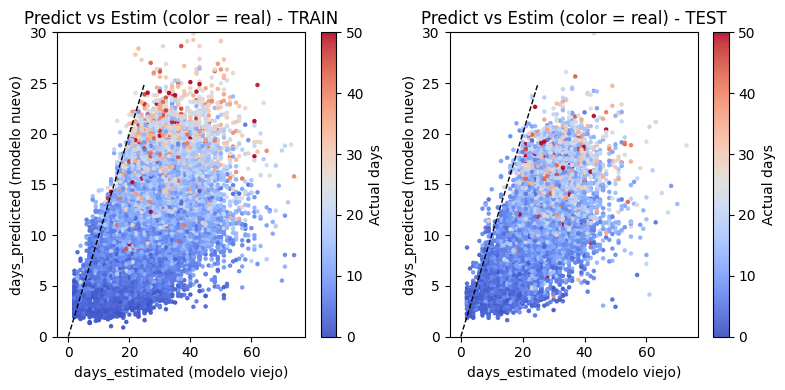

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sc = axes[0].scatter(y_train['days_estimated'], y_train['days_predicted'], c=y_train['days_to_delivered'],
                     cmap='coolwarm', vmin=0, vmax=50, alpha=0.9, s=5)
plt.colorbar(sc, label='Actual days')
axes[0].plot([0, 25], [0, 25], 'k--', lw=1)
axes[0].set_ylim(0,30)
axes[0].set_xlabel('days_estimated (modelo viejo)')
axes[0].set_ylabel('days_predicted (modelo nuevo)')
axes[0].set_title('Predict vs Estim (color = real) - TRAIN')

sc2 = axes[1].scatter(y_test['days_estimated'], y_test['days_predicted'], c=y_test['days_to_delivered'],
                      cmap='coolwarm', vmin=0, vmax=50, alpha=0.9, s=5)
plt.colorbar(sc2, label='Actual days')
axes[1].plot([0, 25], [0, 25], 'k--', lw=1)
axes[1].set_ylim(0,30)
axes[1].set_xlabel('days_estimated (modelo viejo)')
axes[1].set_ylabel('days_predicted (modelo nuevo)')
axes[1].set_title('Predict vs Estim (color = real) - TEST')
plt.tight_layout()
plt.show()

Es interesante notar que por un lado tienen "la misma forma" tanto en train como en test... la información obtenida en el entrenamiento parece reproducir bien información en el dataset test (que no había sido vista antes).

También notemos que la línea diagonal $x=y$ es donde nuestro modelo coincide con la estimación orginal (vieja). La mayoría de puntos caen debajo de esa línea, es decir que se predicen menos días de entrega que el modelo viejo. Nuestro modelo entonces mejora la estimación, recordemos que **en promedio** los paquetes llegaban 11 días antes que la fecha originalmente estimada.

De manera similar podemos comparar el promedio de nuestro modelo frente al promedio de los días reales (target), promedio calculado para cada valor de la estimación vieja (dataset):

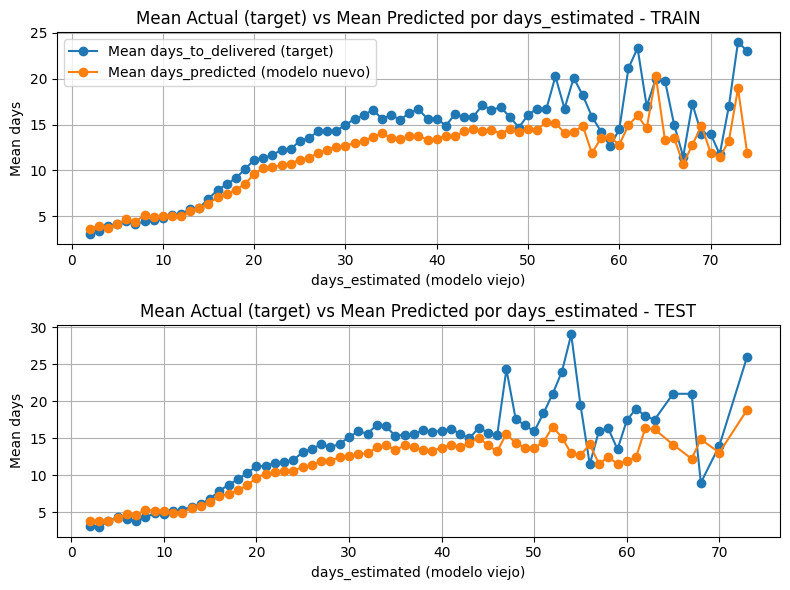

In [98]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
agg0 = y_train.groupby('days_estimated').agg(mean_actual=('days_to_delivered','mean'), mean_pred=('days_predicted','mean')).reset_index()
axes[0].plot(agg0['days_estimated'], agg0['mean_actual'], label='Mean days_to_delivered (target)', marker='o')
axes[0].plot(agg0['days_estimated'], agg0['mean_pred'], label='Mean days_predicted (modelo nuevo)', marker='o')
axes[0].set_xlabel('days_estimated (modelo viejo)') ; axes[0].set_ylabel('Mean days')
axes[0].set_title('Mean Actual (target) vs Mean Predicted por days_estimated - TRAIN')
axes[0].legend() ; axes[0].grid(True)

agg1 = y_test.groupby('days_estimated').agg(mean_actual=('days_to_delivered','mean'), mean_pred=('days_predicted','mean')).reset_index()
axes[1].plot(agg1['days_estimated'], agg1['mean_actual'], label='Mean days_to_delivered (target)', marker='o')
axes[1].plot(agg1['days_estimated'], agg1['mean_pred'], label='Mean days_predicted (modelo nuevo)', marker='o')
axes[1].set_xlabel('days_estimated (modelo viejo)') ; axes[1].set_ylabel('Mean days')
axes[1].set_title('Mean Actual (target) vs Mean Predicted por days_estimated - TEST')
axes[1].grid(True) ; plt.tight_layout()
plt.show()

Vemos que de manera promedio nuestro modelo estima relativamente bien, a excepción de los que estaban catalogados en el dataset con fecha de llegada estimada mayor a ~50 días.
Este rango de datos (estimación vieja mayor a 50 días) fueron aceptablemente reproducidos en entrenamiento, pero no tanto en el test set.

Notemos que en ese rango los días reales de entrega (el target, línea azul) tienen mucha variabilidad. Si agregamos el hecho que elegimos MAE como métrica, tiene sentido encontrarnos con una estimación menos precisa (grandes errores no se pagan más caros).


Comparemos las predicciones de nuestro modelo en los dataset train y test:

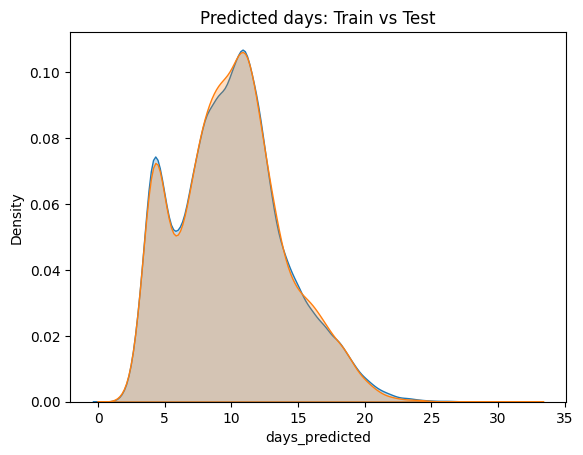

In [99]:
sns.kdeplot(y_train['days_predicted'], label='Train predicted', fill=True)
sns.kdeplot(y_test['days_predicted'], label='Test predicted', fill=True)
plt.title('Predicted days: Train vs Test') ; plt.show()

Esta gráfica no nos agrega mucho, pero nos muestra que las predicciones obtenidas en el test tienen una distribución similar a las obtenidas durante el entrenamiento. Esto es esperable, ya que previamente confirmamos que los datos de train y test tienen distribuciones similares.

Dicho de otra forma, `X_train` y `X_test` expresan el mismo tipo de datos, por lo que en `Y_train` e `Y_test` se obtiene el mismo tipo de resultados.

Por último, grafiquemos los valores reales (target) vs nuestras predicciones, tanto para train como para test:

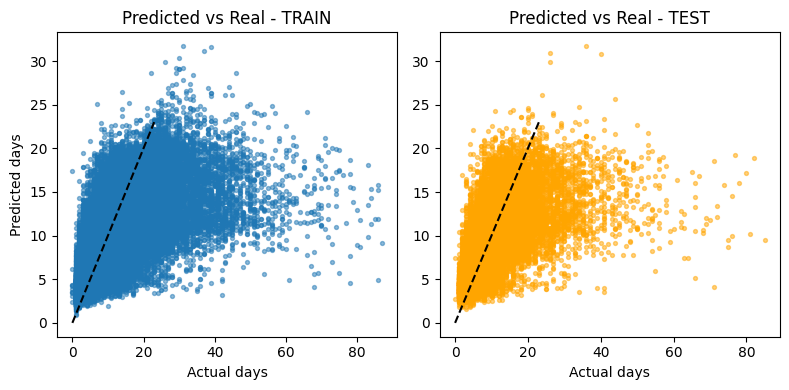

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(y_train['days_to_delivered'], y_train['days_predicted'], s=8, alpha=0.5)
axes[0].plot([0,23],[0,23], 'k--')
axes[0].set_xlabel('Actual days')
axes[0].set_ylabel('Predicted days')
axes[0].set_title('Predicted vs Real - TRAIN')

axes[1].scatter(y_test['days_to_delivered'], y_test['days_predicted'], s=8, alpha=0.5, color='orange')
axes[1].plot([0,23],[0,23], 'k--')
axes[1].set_xlabel('Actual days')
# axes[1].set_ylabel('Predicted days')
axes[1].set_title('Predicted vs Real - TEST')

plt.tight_layout()
plt.show()

Nuestra conclusión parcial es que a nuestro modelo le cuesta estimar correctamente las situaciones donde la entrega se demora muchos días.

Pero también podemos ver que la línea $x=y$ sigue una tendencia que parecería coincidir con el promedio de días reales (Actual days).

In [101]:
y_test['days_predicted'].sort_values().head(5)

51218    1.616605
14151    1.828240
78718    1.841382
58248    1.857400
18882    1.858173
Name: days_predicted, dtype: float32

También observamos que nuestro modelo no predice nunca valores menores a 1.6 días. ¿Qué clase de problema es esto?

### Interpretación de resultados. Variables relevantes.

In [102]:
modelo_final_seleccionado.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['price', 'freight_value',
                                   'product_chosen_weight', 'distance_km',
                                   'sales_same_state']),
                                 ('cat',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['product_venta', 'rutas'])]),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9473671498667567), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mae', feature_types=None, feature_weights=None,
              gamma=np.float64(0.7176274029426006), grow_po

¿Cómo evaluamos la importancia de cada variable?

En XGBoost hay varias maneras de evaluar la importancia de las variables mediante el método `feature_importances_`, como son:

- Weight (o Frequency): Mide el número de veces que se utiliza una variable al dividir nodos en todos los árboles del modelo. Un peso mayor indica un uso más frecuente de dicha variable en la división.
- Gain: Esta métrica cuantifica la ganancia promedio (reducción en la función loss) obtenida al usar una función para dividir entre todos los árboles. Una ganancia mayor indica un impacto más significativo de la variable en el rendimiento del modelo.
- Cover: Esta representa la cobertura promedio de instancias en las divisiones donde se utiliza la variable. Considera el número de datos afectados por una división que involucra esa variable.

Pero estas tres métricas generan resultados muy disímiles.

Es por esto que decidimos utilizar la librería SHAP (SHapley Additive exPlanations).

Según su página:

"SHAP (Explicaciones Aditivas de Shapley) es un enfoque de teoría de juegos para explicar el resultado de cualquier modelo de aprendizaje automático. Conecta la asignación óptima de créditos con explicaciones locales utilizando los valores clásicos de Shapley de la teoría de juegos y sus extensiones relacionadas."


A continuación ofrecemos una breve explicación sencilla de las gráficas SHAP que generaremos con esta librería: 

Para cada predicción del modelo **SHAP nos dice cuánto empuja cada variable la predicción hacia arriba o hacia abajo**,
en comparación con la predicción promedio del modelo.

* Valor SHAP positivo → la característica **aumenta** la predicción
* Valor SHAP negativo → la característica **disminuye** la predicción
* Valor absoluto → **fuerza del efecto**

Esto funciona tanto **por observación** (explicación local) como **en promedio** (explicación global)

En cuánto a las gráficas:

**1. SHAP Summary Plot (Beeswarm)**

Muestra las **variables más importantes** (ordenadas de arriba hacia abajo)

Para cada variable:

  * **Cada punto = una fila del dataset**
  * Posición horizontal = valor SHAP (efecto en la predicción)
  * Color = valor del feature (azul = bajo, rojo = alto)

<u>Cómo interpretarlo:</u>

> “variable que está más arriba → es la variable más influyente.”
>
> “Muchos puntos rojos a la derecha →
> valores grandes de la variable tienden a **aumentar** la predicción.”
>
> “Puntos azules a la izquierda →
> valores bajos de la variable tienden a **reducir** la predicción.”

<u>¿Por qué es útil?</u>

En un solo gráfico muestra:

* Importancia
* Dirección del efecto
* No linealidades
* Interacciones

**2. SHAP Bar Plot**

Barra horizontal con importancias.

Muestra la **importancia global** de cada característica según el promedio de |SHAP|.

<u>Cómo interpretarlo:</u>

Ejemplo:

> “variable_A = 0.12”
> → En promedio, esta variable cambia la predicción ±0.12 (en unidades del modelo).

<u>¿Por qué es útil?</u>

* Más simple que el beeswarm
* Muestra solo **importancia**, no dirección
* Ideal para reportes ejecutivos

**3. SHAP Grouped Importance Plot**

Es un bar plot pero que agrupa las categorías one-hot en una sola variable original.

Muestra la contribución total de una variable original, aunque tenga muchas columnas codificadas.

<u>¿Por qué es útil?</u>

SHAP permite recuperar la importancia real de variables categóricas completas.

In [103]:
import shap

In [104]:
model = modelo_final_seleccionado.named_steps['xgb']
preprocessor = modelo_final_seleccionado.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()
X_train_transformed = preprocessor.transform(X_train)

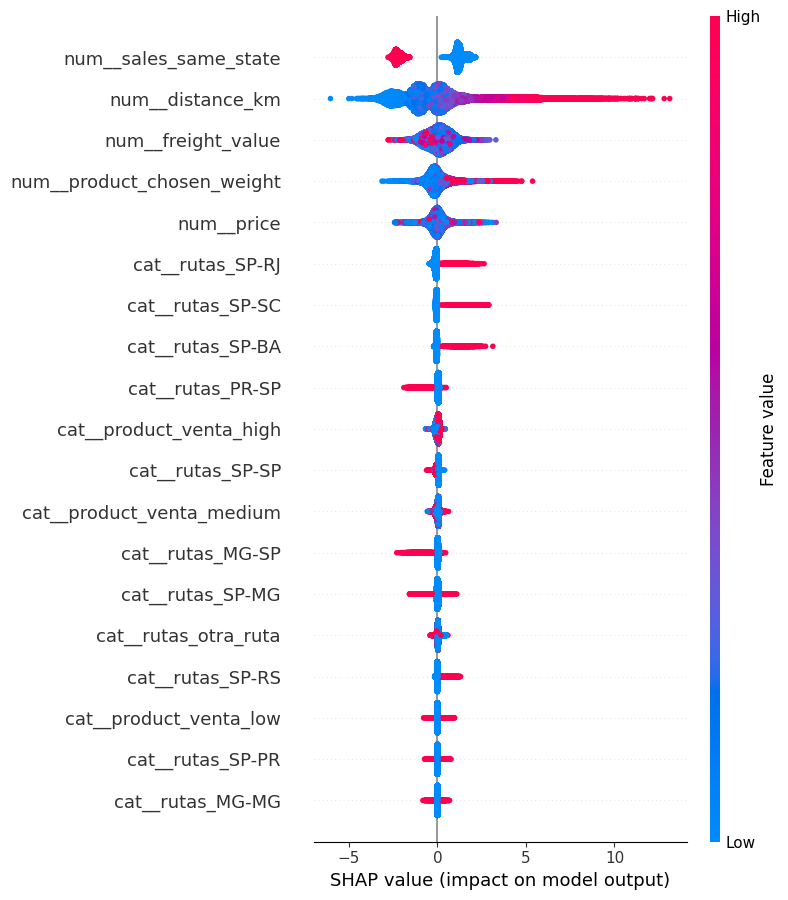

In [105]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values, features=X_train_transformed, feature_names=feature_names)

In [109]:
 # Compute mean absolute SHAP importance
shap_importance = pd.DataFrame({"feature": feature_names, "mean_abs_shap": np.abs(shap_values).mean(axis=0)})
shap_importance_sorted = shap_importance.sort_values("mean_abs_shap", ascending=False)

shap_importance_sorted['percentage'] = 100 * (shap_importance_sorted['mean_abs_shap'] / shap_importance_sorted['mean_abs_shap'].sum())
shap_importance_sorted

,feature,mean_abs_shap,percentage
4,num__sales_same_state,1.619934,30.479548
3,num__distance_km,1.564298,29.432737
1,num__freight_value,0.515558,9.700372
2,num__product_chosen_weight,0.420056,7.903483
0,num__price,0.300671,5.657210
14,cat__rutas_SP-RJ,0.194693,3.663199
16,cat__rutas_SP-SC,0.090470,1.702224
11,cat__rutas_SP-BA,0.077143,1.451470
10,cat__rutas_PR-SP,0.071479,1.344903
5,cat__product_venta_high,0.071029,1.336424


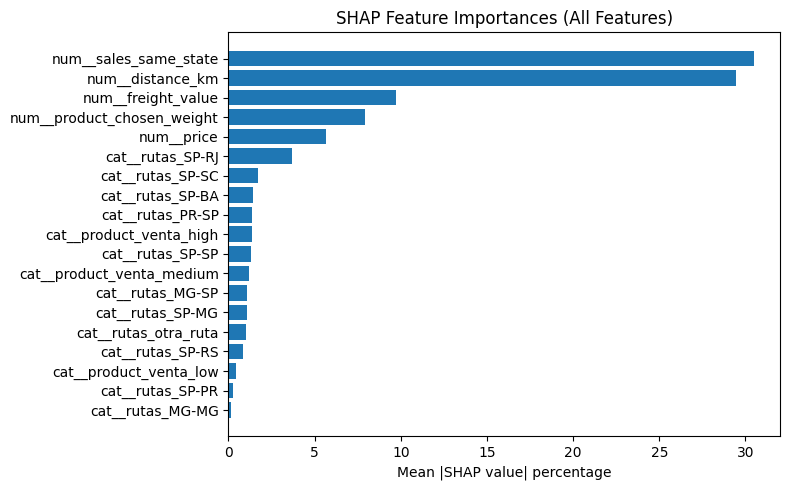

In [119]:
plt.figure(figsize=(8, max(5, len(shap_importance_sorted) * 0.25))) 
plt.barh(shap_importance_sorted["feature"], shap_importance_sorted["percentage"])
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP value| percentage") ; plt.title("SHAP Feature Importances (All Features)")
plt.tight_layout() ; plt.show()

Vemos que las 5 variables mas importantes dan cuenta del 83% del valor "SHAP" medio (explicación global).

Estas 5 características que más explican el target son (por orden de importancia):

* Si la venta es dentro de un mismo estado (provincia)
* La distancia entre vendedor y comprador
* Valor del flete
* Peso efectivo para flete (peso real o peso volumétrico, el que sea mayor)
* Precio del producto

Cabe remarcar que la variable que cataloga el volumen de venta en bajo, medio y alto tiene muy bajo poder explicativo. Por lo tanto podemos ver de omitirla en caso de reentrenar el modelo.

In [122]:
# ----------------------------------------------------
#   Extract ORIGINAL variable names
# ----------------------------------------------------
def original_var_name(encoded_name):
    # Split at "__", take second part
    no_prefix = encoded_name.split("__", 1)[1]
    # "rutas_R1" → "rutas"
    return no_prefix.split("_")[0]

## OJO: previamente modificamos el nombre de num__product_chosen_weight
## Porque de no hacerlo nos juntaría el peso de esta variable con la de num__product_venta
shap_importance.iloc[2,0] = 'num__weight_chosen'
# ==============================================
shap_importance["original_var"] = shap_importance["feature"].apply(original_var_name)

shap_grouped = (
    shap_importance.groupby("original_var")["mean_abs_shap"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

shap_grouped['percentage'] = 100 * (shap_grouped['mean_abs_shap'] / shap_grouped['mean_abs_shap'].sum())
shap_grouped

,original_var,mean_abs_shap,percentage
0,sales,1.619934,30.479548
1,distance,1.564298,29.432737
2,rutas,0.739435,13.912686
3,freight,0.515558,9.700372
4,weight,0.420056,7.903483
5,price,0.300671,5.657210
6,product,0.154872,2.913965


In [124]:
# Cambiamos los nombres para que sean más representativos
shap_grouped.iloc[0,0] = 'same_state'
shap_grouped.iloc[6,0] = 'product_volume'

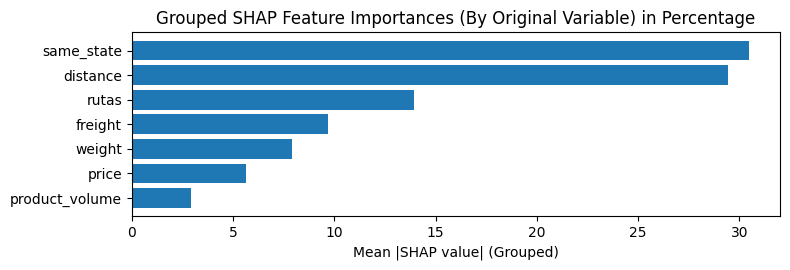

In [125]:
plt.figure(figsize=(8, max(2, len(shap_grouped) * 0.4)))
plt.barh(shap_grouped["original_var"], shap_grouped["percentage"])
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP value| (Grouped)") ; plt.title("Grouped SHAP Feature Importances (By Original Variable) in Percentage")
plt.tight_layout() ; plt.show()

En esta última gráfica de importancia por variable original, podemos ver que distancia y venta intra-estado acumulan el 60% de la importancia, mientras que la variable que etiqueta el volumen de venta es la de menor importancia.

Surge la pregunta si hay alguna relación entre la varaible que etiqueta las rutas (las 10 con más volumen de ventas) y la varaible binaria que identifica intra-estado. Como vimos antes, la provincia de Sao Paulo acumula muchos vendedores y muchos compradores, y quizás ambas variables no midan propiedades tan disímiles.

Veamos entonces ¿Qué rutas conforman las ventas intra-estado? es decir con `sales_same_state=1`

In [126]:
df_final[df_final['sales_same_state']==1]['rutas'].value_counts()

rutas
SP-SP        28498
otra_ruta     2298
MG-MG         1468
Name: count, dtype: int64

Como vemos, del total de órdenes con `sales_same_state=1` el 88 % son de la `rutas='SP-SP'`.

<u> **Algunas conclusiones:** </u>

- En caso de reentrenar el modelo podemos descartar la variable que categoriza según el volumen vendido de cada categoría de producto `Product_venta`.

- También puede repensarse la categorización de las rutas y de las ventas entre o intra-estados:
  - `sales_same_state` tiene peso de importancia en nuestro modelo, pero también lo hace la ruta SP-SP, que es la que conforma la gran mayoría de las ventas intra-estado.
  - En cambio las rutas "otra_ruta" y "MG-MG", que conforman el resto de ventas intra-estados, parecen tener importancia muy baja en el modelo.
  
  **Una opción es que, similarmente a `product_venta`, podemos descartar la variable `rutas` a la hora de tener que reentrenar el modelo, ya que `sales_same_state` parece ser suficiente.**
  **Alternativamente, quizás baste con diferenciar solamente SP-SP del resto para obtener una performance similar.**
  

### Evaluación de performances

Queremos ahora evaluar la performance del modelo en distintas situaciones. Por ejemplo para cada tipo de ruta (estado-estado), distintos rangos de precio de flete, etc.

Armamos primero los datasets ya escalados, para poder evaluar directamente el modelo:

In [128]:
X_train_scaled = modelo_final_seleccionado.named_steps['preprocessor'].transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = modelo_final_seleccionado.named_steps['preprocessor'].transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [129]:
# Armamos lo mismo pero para todo el data set
X_total = df_final[numerical_features + categorical_features]
y_total = df_final[target_columns]
y_total['days_predicted']=modelo_final_seleccionado.predict(X_total)

X_total_scaled = modelo_final_seleccionado.named_steps['preprocessor'].transform(X_total)
X_total_scaled = pd.DataFrame(X_total_scaled, columns=feature_names)

#### Variable `rutas`

Como vimos previamente, esta variable posee cierta importancia en el modelo (especialmente algunas rutas), por lo que esperamos ver acá dos cosas:

- Los días de entrega (`days_to_delivered`) cambiarán cuando cambie el valor de esta variable, y nuestro modelo reproducirá ese cambio. Esto lo veremos a través de los valores promedio para cada ruta.

- Es posible que nuestro modelo prediga mucho mejor para distintos valores de esta variable. Esto lo veremos a través del cálculo de MAE para cada ruta

In [130]:
orden_rutas = df_final['rutas'].value_counts().index.tolist()

In [131]:
df_rutas = pd.concat([
    df_final['rutas'],
    y_total[['days_to_delivered', 'days_estimated', 'days_predicted']]
], axis=1)

In [135]:
score_por_ruta = pd.DataFrame(columns=['rutas', 'rmse', 'mae'])
dias_promedio_por_ruta = pd.DataFrame(columns=['rutas', 'days_to_delivered', 'days_estimated', 'days_predicted'])
for ruta in orden_rutas:
    df_ruta = df_rutas[df_rutas['rutas'] == ruta]
    mae = mean_absolute_error(df_ruta['days_to_delivered'], df_ruta['days_predicted'])
    rmse = root_mean_squared_error(df_ruta['days_to_delivered'], df_ruta['days_predicted'])
    score_por_ruta.loc[len(score_por_ruta)] = [ruta, rmse, mae]

    dias_promedio_por_ruta.loc[len(dias_promedio_por_ruta)] = [ruta,
                                                               df_ruta['days_to_delivered'].mean(),
                                                               df_ruta['days_estimated'].mean(),
                                                               df_ruta['days_predicted'].mean()]
score_por_ruta

,rutas,rmse,mae
0,otra_ruta,7.745343,4.779593
1,SP-SP,4.570978,2.639333
2,SP-RJ,10.536455,6.325463
3,SP-MG,5.789855,3.672784
4,SP-RS,8.034685,5.048276
5,SP-PR,6.162920,3.787593
6,PR-SP,5.005255,3.121922
7,MG-SP,5.247682,3.183382
8,SP-SC,7.223158,4.845372
9,SP-BA,8.866972,5.878220


Vemos que los valores mas bajos de MAE por ruta ocurren en MG-MG, SP-SP, PR-SP, MG-SP, SP-MG. Sus valores de MAE son bastante mas bajos que el nivel general de todos los datos (~4.4).

También resultan tener los valores más bajos de RMSE.

MG-MG tiene un MAE pequeño, a pesar de que vimos antes que su importancia en el modelo no es relevante. Esto se debe a que son pocas ventas, comparadas con SP-SP.

El resto de compras dentro de un mismo estado quedaron fuera de esta primer segmentación, y se encuentran en el valor "otra_ruta".

- Como MG-MG y SP-SP son las rutas con mejor performance, podemos concluir nuevamente que la variable `sales_same_state` es más relevante para el modelo que `rutas`.

- Recordemos también que al calcular la importancia por variable original agrupada también seguía siendo `sales_same_state` más importante que `rutas`.

Grafiquemos por último los días promedio para cada ruta:

In [137]:
orden_rutas_mae = score_por_ruta.sort_values('mae', ascending=True)['rutas'].tolist()
orden_rutas_mae

['MG-MG',
 'SP-SP',
 'PR-SP',
 'MG-SP',
 'SP-MG',
 'SP-PR',
 'otra_ruta',
 'SP-SC',
 'SP-RS',
 'SP-BA',
 'SP-RJ']

In [139]:
maes = score_por_ruta.sort_values('mae', ascending=True)['mae'].round(2).tolist()
maes

[2.46, 2.64, 3.12, 3.18, 3.67, 3.79, 4.78, 4.85, 5.05, 5.88, 6.33]

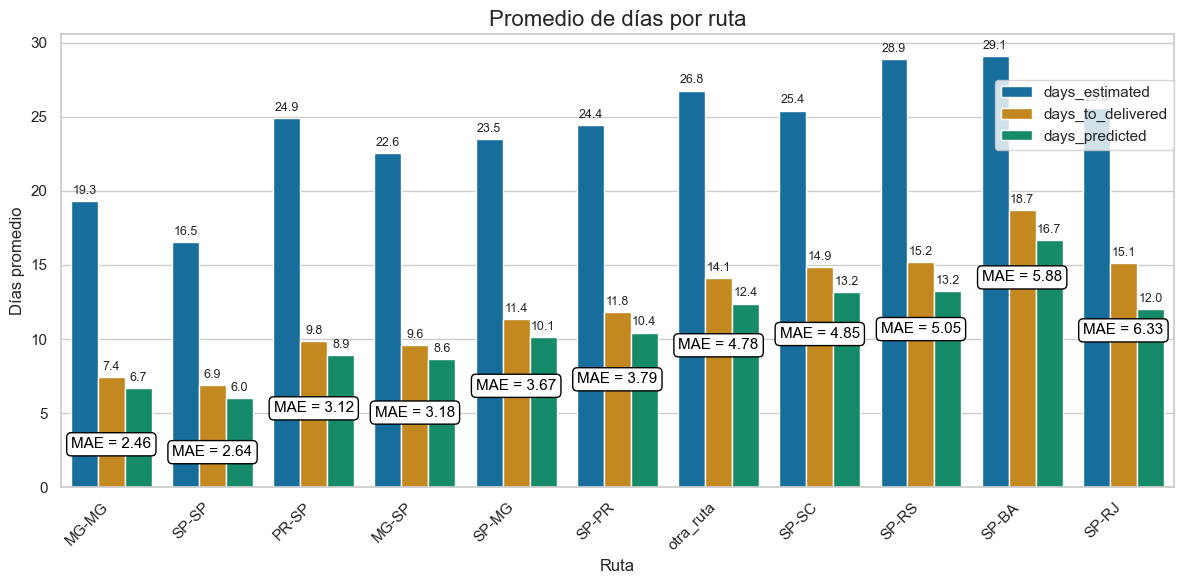

In [140]:
# Reorganizamos los datos a formato largo para Seaborn
df_melted = dias_promedio_por_ruta.melt(
    id_vars='rutas',
    value_vars=['days_estimated', 'days_to_delivered', 'days_predicted'],
    var_name='Tipo',
    value_name='Días promedio')

sns.set(style='whitegrid', palette='colorblind')
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, x='rutas', y='Días promedio', hue='Tipo', order=orden_rutas_mae) #order=orden_rutas)

# --- Agregar cuadros con valores de MAE distintos por grupo ---
mae_values = maes

# Obtener posiciones de cada grupo (centros en el eje x)
group_positions = ax.get_xticks()

for pos, mae in zip(group_positions, mae_values):
    # Obtener las barras cercanas a esa posición
    group_bars = [bar for bar in ax.patches if abs(bar.get_x() + bar.get_width()/2 - pos) < 0.2]
    if group_bars:
        y_max = max(bar.get_height() for bar in group_bars)
        ax.text(
            pos, y_max -5,  # ajusta "+1" según la escala del eje y
            f'MAE = {mae:.2f}',
            ha='center', va='bottom',
            fontsize=11, color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
        )

# Etiquetas de valor encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=9)

plt.title('Promedio de días por ruta', fontsize=16)
plt.xlabel('Ruta', fontsize=12) ; plt.xticks(rotation=45, ha='right') ; plt.ylabel('Días promedio', fontsize=12)
plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right', borderaxespad=0.)
plt.tight_layout() ; plt.show()


Vemos que, al menos en promedio, la variabilidad del target es explicada por la feature `rutas`.

#### Variable `product_venta`

Como vimos antes, los 3 valores de esta variable están dentro de las 5 features menos importantes del modelo.

Haciendo un análisis similar al de `rutas`, podemos esperar entonces lo siguiente:

- No va a explicar la variabilidad del target, entonces el promedio de `days_to_delivered` será similar para los tres valores de `product_venta`.

- Podemos llegar a esperar que el MAE para los datos de  estas 3 categorías tampoco difieran entre si.

In [141]:
df_ventas = pd.concat([
    df_final['product_venta'],
    y_total[['days_to_delivered', 'days_estimated', 'days_predicted']]
], axis=1)

In [142]:
score_por_ventas = pd.DataFrame(columns=['product_venta', 'rmse', 'mae'])
dias_promedio_ventas = pd.DataFrame(columns=['product_venta', 'days_to_delivered', 'days_estimated', 'days_predicted'])
for vol in ['low','medium','high']:
    df_nivel = df_ventas[df_ventas['product_venta'] == vol]
    mae = mean_absolute_error(df_nivel['days_to_delivered'], df_nivel['days_predicted'])
    rmse = root_mean_squared_error(df_nivel['days_to_delivered'], df_nivel['days_predicted'])
    score_por_ventas.loc[len(score_por_ventas)] = [vol, rmse, mae]

    dias_promedio_ventas.loc[len(dias_promedio_ventas)] = [vol,
                                                           df_nivel['days_to_delivered'].mean(),
                                                           df_nivel['days_estimated'].mean(),
                                                           df_nivel['days_predicted'].mean()]
score_por_ventas

,product_venta,rmse,mae
0,low,6.502620,3.817997
1,medium,6.833225,3.995838
2,high,6.912298,4.070978


Vemos que el MAE no cambia considerablemente para los distintos valores de la varaible `product_venta`

In [143]:
maes = score_por_ventas.sort_values('mae', ascending=True)['mae'].round(2).tolist()
maes

[3.82, 4.0, 4.07]

Graficando valores medios de días:

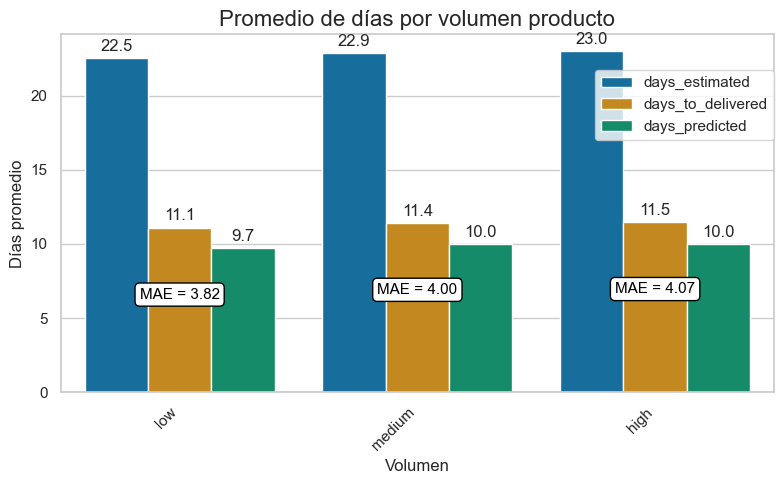

In [144]:
# Reorganizamos los datos a formato largo para Seaborn
df_melted = dias_promedio_ventas.melt(
    id_vars='product_venta',
    value_vars=['days_estimated', 'days_to_delivered', 'days_predicted'],
    var_name='Tipo',
    value_name='Días promedio')

sns.set(style='whitegrid', palette='colorblind')
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_melted, x='product_venta', y='Días promedio', hue='Tipo')

# --- Agregar cuadros con valores de MAE distintos por grupo ---
mae_values = maes

# Obtener posiciones de cada grupo (centros en el eje x)
group_positions = ax.get_xticks()

for pos, mae in zip(group_positions, mae_values):
    # Obtener las barras cercanas a esa posición
    group_bars = [bar for bar in ax.patches if abs(bar.get_x() + bar.get_width()/2 - pos) < 0.2]
    if group_bars:
        y_max = max(bar.get_height() for bar in group_bars)
        ax.text(
            pos, y_max -5,  # ajusta "+1" según la escala del eje y
            f'MAE = {mae:.2f}',
            ha='center', va='bottom',
            fontsize=11, color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
        )

# Etiquetas de valor encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=12)

plt.title('Promedio de días por volumen producto', fontsize=16)
plt.xlabel('Volumen', fontsize=12) ; plt.xticks(rotation=45, ha='right') ; plt.ylabel('Días promedio', fontsize=12)
plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right', borderaxespad=0.)
plt.tight_layout() ; plt.show()

Acá podemos confirmar nuevamente que esta variable no es explicativa.

#### Variable `sales_same_state`

Esta es la variable con más importancia.

In [145]:
df_same_state = pd.concat([
    df_final['sales_same_state'],
    y_total[['days_to_delivered', 'days_estimated', 'days_predicted']]
], axis=1)

In [146]:
score_same_state = pd.DataFrame(columns=['same_state', 'rmse', 'mae'])
dias_promedio_same_state = pd.DataFrame(columns=['sales_same_state', 'days_to_delivered', 'days_estimated', 'days_predicted'])
for same in [1,0]:
    df_nivel = df_same_state[df_same_state['sales_same_state'] == same]
    mae = mean_absolute_error(df_nivel['days_to_delivered'], df_nivel['days_predicted'])
    rmse = root_mean_squared_error(df_nivel['days_to_delivered'], df_nivel['days_predicted'])
    score_same_state.loc[len(score_same_state)] = [same, rmse, mae]

    dias_promedio_same_state.loc[len(dias_promedio_same_state)] = [same,
                                                                   df_nivel['days_to_delivered'].mean(),
                                                                   df_nivel['days_estimated'].mean(),
                                                                   df_nivel['days_predicted'].mean()]
score_same_state

,same_state,rmse,mae
0,1.0,4.559778,2.624739
1,0.0,7.842797,4.801049


Vemos que el MAE se reduce considerablemente para las órdenes donde vendedor y comprador son del mismo estado.

In [147]:
maes = score_same_state.sort_values('mae', ascending=True)['mae'].round(2).tolist()
maes

[2.62, 4.8]

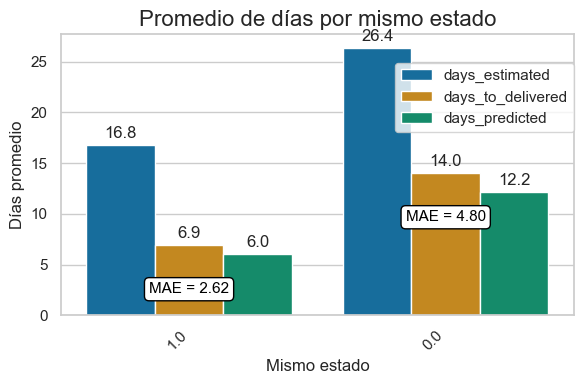

In [148]:
df_melted = dias_promedio_same_state.melt(
    id_vars='sales_same_state',
    value_vars=['days_estimated', 'days_to_delivered', 'days_predicted'],
    var_name='Tipo',
    value_name='Días promedio')

sns.set(style='whitegrid', palette='colorblind')
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=df_melted, x='sales_same_state', y='Días promedio', hue='Tipo', order=[1.,0.])

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=12)

# --- Agregar cuadros con valores de MAE distintos por grupo ---
mae_values = maes  # un valor por grupo, en el mismo orden que 'order'

# Obtener posiciones de cada grupo (centros en el eje x)
group_positions = ax.get_xticks()

for pos, mae in zip(group_positions, mae_values):
    # Obtener las barras cercanas a esa posición
    group_bars = [bar for bar in ax.patches if abs(bar.get_x() + bar.get_width()/2 - pos) < 0.2]
    if group_bars:
        y_max = max(bar.get_height() for bar in group_bars)
        ax.text(
            pos, y_max -5,  # ajusta "+1" según la escala del eje y
            f'MAE = {mae:.2f}',
            ha='center', va='bottom',
            fontsize=11, color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
        )

plt.title('Promedio de días por mismo estado', fontsize=16)
plt.xlabel('Mismo estado', fontsize=12) ; plt.xticks(rotation=45, ha='right') ; plt.ylabel('Días promedio', fontsize=12)
plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right', borderaxespad=0.)
plt.tight_layout() ; plt.show()

#### Variable `distance_km`

Esta es la variable también es muy importante.

Al ser una variable continua, podemos dividirla en tramos y ver como se comporta el promedio de la predicción en cada uno de ellos.

In [149]:
df_distancia = pd.concat([
    df_final['distance_km'],
    y_total[['days_to_delivered', 'days_estimated', 'days_predicted']]
], axis=1)

In [150]:
# Definimos los tramos
max_val = df_distancia['distance_km'].max()
bins = [0, 250, 500, 750, 1000, max_val]
labels = ['0–250 km', '251–500 km', '501–750 km', '751–1000 km', f'1001–{int(max_val)} km']
# Creamos la variable categórica de tramos
df_distancia['distance_range'] = pd.cut(df_distancia['distance_km'], bins=bins, labels=labels, include_lowest=True)

In [151]:
score_por_distancia = pd.DataFrame(columns=['distance', 'rmse', 'mae'])
dias_promedio_distancia = pd.DataFrame(columns=['distance', 'days_to_delivered', 'days_estimated', 'days_predicted'])
for range in labels:
    df_nivel = df_distancia[df_distancia['distance_range'] == range]
    mae = mean_absolute_error(df_nivel['days_to_delivered'], df_nivel['days_predicted'])
    rmse = root_mean_squared_error(df_nivel['days_to_delivered'], df_nivel['days_predicted'])
    score_por_distancia.loc[len(score_por_distancia)] = [range, rmse, mae]

    dias_promedio_distancia.loc[len(dias_promedio_distancia)] = [range,
                                                               df_nivel['days_to_delivered'].mean(),
                                                               df_nivel['days_estimated'].mean(),
                                                               df_nivel['days_predicted'].mean()]
score_por_distancia

,distance,rmse,mae
0,0–250 km,4.534581,2.566962
1,251–500 km,6.947136,4.050078
2,501–750 km,7.411861,4.482806
3,751–1000 km,7.357663,4.611116
4,1001–3384 km,8.848303,5.677391


In [152]:
maes = score_por_distancia['mae'].round(2).to_list()
maes

[2.57, 4.05, 4.48, 4.61, 5.68]

El menor MAE lo tienen las órdenes que viajan menos de 250 km (lo cual se condice con las órdenes que se trasladan dentro del mismo estado/provincia).

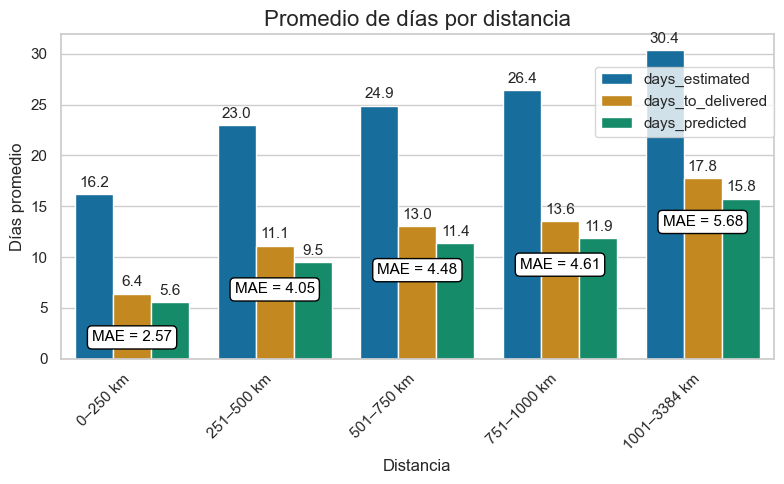

In [153]:
df_melted = dias_promedio_distancia.melt(
    id_vars='distance',
    value_vars=['days_estimated', 'days_to_delivered', 'days_predicted'],
    var_name='Tipo',
    value_name='Días promedio')

sns.set(style='whitegrid', palette='colorblind')
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_melted, x='distance', y='Días promedio', hue='Tipo')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=11)

# --- Agregar cuadros con valores de MAE distintos por grupo ---
mae_values = maes  # un valor por grupo, en el mismo orden que 'order'

# Obtener posiciones de cada grupo (centros en el eje x)
group_positions = ax.get_xticks()

for pos, mae in zip(group_positions, mae_values):
    # Obtener las barras cercanas a esa posición
    group_bars = [bar for bar in ax.patches if abs(bar.get_x() + bar.get_width()/2 - pos) < 0.2]
    if group_bars:
        y_max = max(bar.get_height() for bar in group_bars)
        ax.text(
            pos, y_max -5,  # ajusta "+1" según la escala del eje y
            f'MAE = {mae:.2f}',
            ha='center', va='bottom',
            fontsize=11, color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
        )

plt.title('Promedio de días por distancia', fontsize=16)
plt.xlabel('Distancia', fontsize=12) ; plt.xticks(rotation=45, ha='right') ; plt.ylabel('Días promedio', fontsize=12)
plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right', borderaxespad=0.)
plt.tight_layout() ; plt.show()

#### Variable precio de flete `freight_value`

Haremos algo similar al agrupamiento de `distance_km`, pero lo dividiremos en cuartilos.

In [154]:
df_flete = pd.concat([
    df_final['freight_value'],
    y_total[['days_estimated', 'days_to_delivered', 'days_predicted']]
], axis=1)

In [155]:
# definimos los cuartilos
quartiles = df_flete['freight_value'].quantile([0, 0.25, 0.5, 0.75, 1.0]).values

# Creamos etiquetas descriptivas con los límites redondeados
labels = [
    f'Q1: {quartiles[0]:.0f}–{quartiles[1]:.0f}',
    f'Q2: {quartiles[1]:.0f}–{quartiles[2]:.0f}',
    f'Q3: {quartiles[2]:.0f}–{quartiles[3]:.0f}',
    f'Q4: {quartiles[3]:.0f}–{quartiles[4]:.0f}'
]

# Discretizamos la variable en cuartiles
df_flete['freight_quartile'] = pd.cut(df_flete['freight_value'], bins=quartiles, labels=labels, include_lowest=True)


In [156]:
score_por_flete = pd.DataFrame(columns=['freight_q', 'rmse', 'mae'])
dias_promedio_flete = pd.DataFrame(columns=['freight_q', 'days_to_delivered', 'days_estimated', 'days_predicted'])
for quart in labels:
    df_nivel = df_flete[df_flete['freight_quartile'] == quart]
    mae = mean_absolute_error(df_nivel['days_to_delivered'], df_nivel['days_predicted'])
    rmse = root_mean_squared_error(df_nivel['days_to_delivered'], df_nivel['days_predicted'])
    score_por_flete.loc[len(score_por_flete)] = [quart, rmse, mae]

    dias_promedio_flete.loc[len(dias_promedio_flete)] = [quart,
                                                         df_nivel['days_to_delivered'].mean(),
                                                         df_nivel['days_estimated'].mean(),
                                                         df_nivel['days_predicted'].mean()]
score_por_flete

,freight_q,rmse,mae
0,Q1: 0–14,4.693229,2.630355
1,Q2: 14–17,7.147067,4.240353
2,Q3: 17–24,7.535894,4.580248
3,Q4: 24–503,7.607078,4.638669


Nuestro modelo predice muy bien para los precios de flete que se ubican en el primer cuartil.

- Por un lado, tiene sentido identificar las órdenes con precios de flete mas bajo con las que duran menos días en entregarse, que recorren menor distancia y que son dentro de un mismo estado.

- Y por otro lado, todas esas características son las que hemos visto nuestro modelo posee mejor performance. Por lo tanto los precios de flete más bajo son también del subgrupo que nuestro modelo predice mejor.

In [157]:
maes = score_por_flete['mae'].round(2).to_list()
maes

[2.63, 4.24, 4.58, 4.64]

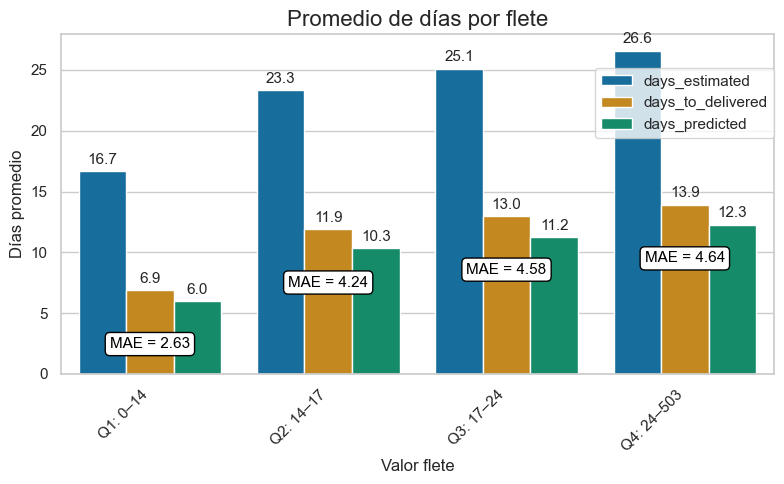

In [158]:
df_melted = dias_promedio_flete.melt(
    id_vars='freight_q',
    value_vars=['days_estimated', 'days_to_delivered', 'days_predicted'],
    var_name='Tipo',
    value_name='Días promedio')

sns.set(style='whitegrid', palette='colorblind')
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_melted, x='freight_q', y='Días promedio', hue='Tipo', order=labels)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=11)


# --- Agregar cuadros con valores de MAE distintos por grupo ---
mae_values = maes  # un valor por grupo, en el mismo orden que 'order'

# Obtener posiciones de cada grupo (centros en el eje x)
group_positions = ax.get_xticks()

for pos, mae in zip(group_positions, mae_values):
    # Obtener las barras cercanas a esa posición
    group_bars = [bar for bar in ax.patches if abs(bar.get_x() + bar.get_width()/2 - pos) < 0.2]
    if group_bars:
        y_max = max(bar.get_height() for bar in group_bars)
        ax.text(
            pos, y_max -5,  # ajusta "+1" según la escala del eje y
            f'MAE = {mae:.2f}',
            ha='center', va='bottom',
            fontsize=11, color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
        )

plt.title('Promedio de días por flete', fontsize=16)
plt.xlabel('Valor flete', fontsize=12) ; plt.xticks(rotation=45, ha='right') ; plt.ylabel('Días promedio', fontsize=12)
plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right', borderaxespad=0.)
plt.tight_layout() ; plt.show()

### Conclusiones y pasos futuros

#### Conclusión

Para concluir y resumir lo hecho en el trabajo, determinamos que en base a la oportunidad de mejora planteada inicialmente (mejoría en estimación de días de entrega) el modelo con mejor performance es XGBoost.

Luego de analizar la importancia y performance de cada variable del modelo, podemos concluir que:

- Los días reales de entrega se estiman con mayor precisión utilizando las siguientes variables:
  - Distancia en km entre comprador y vendedor
  - Órdenes de compra dentro del mismo estado
  - Valor de flete
  - Ruta comprador-vendedor (menos incidencia, ya que tiene su correlato en la segunda variable nombrada)

#### A mejorar a futuro

- Incorporar los datos de reviews:
  
  Se puede analizar si la calificación de ventas  realizadas por compradores guarda relación con los tiempos de entrega. Si esto fuera afirmativo, los valores de reviews pasados son relevantes para realizar una segmentación de los vendedores.
  
  Esto puede también combinarse con la cantidad de días que demora el vendedor en despachar el producto, para así definir una variable de "score" del vendedor.


- Acotar rango temporal de análisis:

  Para mejorar la eficacia de los días estimados, podríamos acotar el rango de tiempo de los datos para entrenamiento al año 2018 donde el volumen de ventas era mayor y estable, y donde la estimación de entrega original era más precisa.